<a href="https://colab.research.google.com/github/Asma-Ahmed-Aqil-AL-Zubaidi/Multi-Model-Image-Classification-Clustering-CIFAR10/blob/main/DL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install & import required libraries

In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Conv2D, SeparableConv2D, MaxPooling2D,
                                     UpSampling2D, BatchNormalization, Dropout,
                                     Flatten, Dense, GlobalAveragePooling2D)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import mixed_precision
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                              f1_score, confusion_matrix, classification_report,
                              adjusted_rand_score)
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from IPython import get_ipython
from IPython.display import display
import matplotlib.ticker as mtick

ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

# Load CIFAR-10 dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

# Explore dataset

In [ ]:
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Unique labels: {np.unique(y_train)}")
print(f"Number of classes: {len(class_names)}")

Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Number of classes: 10


ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

# Convert labels to 1D array

In [ ]:
y_train = y_train.flatten()
y_test = y_test.flatten()

ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

# Count samples per class

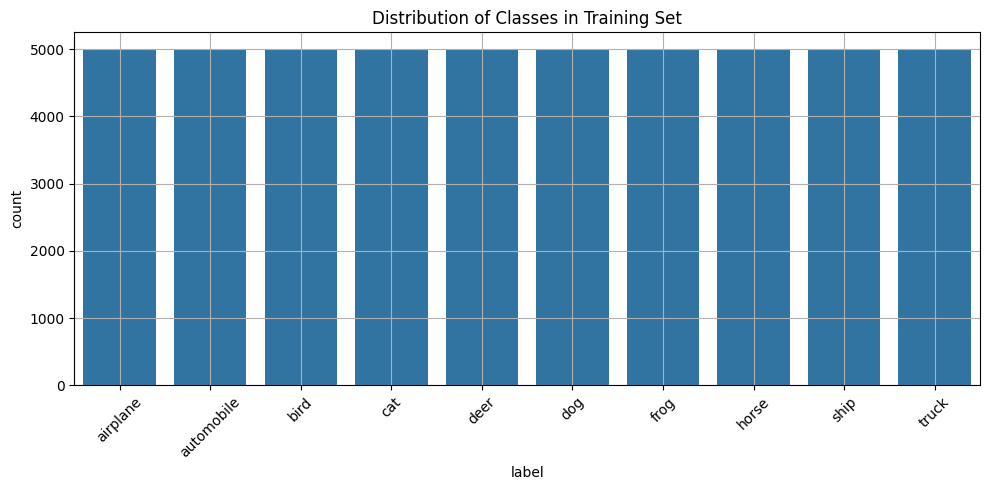

In [ ]:
train_df = pd.DataFrame({'label': y_train})
plt.figure(figsize=(10,5))
sns.countplot(data=train_df, x='label')
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45)
plt.title('Distribution of Classes in Training Set')
plt.grid(True)
plt.tight_layout()
plt.show()


# Count per class numerically

In [ ]:
labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(labels, counts):
    print(f"{class_names[label]}: {count} samples")


airplane: 5000 samples
automobile: 5000 samples
bird: 5000 samples
cat: 5000 samples
deer: 5000 samples
dog: 5000 samples
frog: 5000 samples
horse: 5000 samples
ship: 5000 samples
truck: 5000 samples


# Balanced Dataset

ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

# Show 10 sample images (one per class)

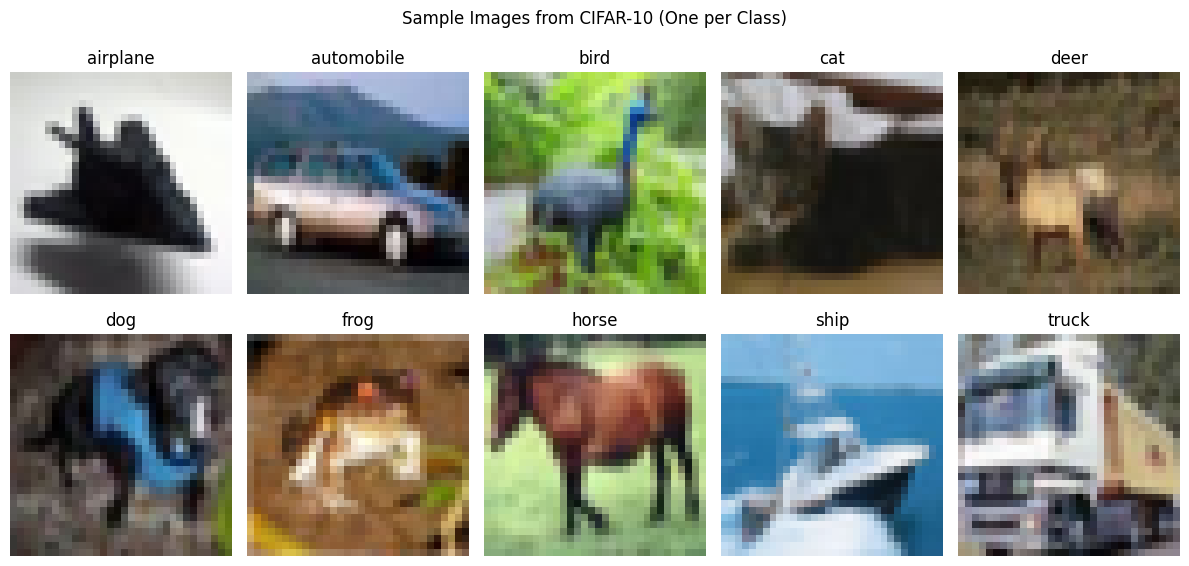

In [ ]:
plt.figure(figsize=(12,6))
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle("Sample Images from CIFAR-10 (One per Class)")
plt.tight_layout()
plt.show()

ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

# Check shape and range

In [ ]:
print("Image shape:", x_train[0].shape)
print("Pixel value range:", np.min(x_train), "to", np.max(x_train))

Image shape: (32, 32, 3)
Pixel value range: 0 to 255


# Result:

I need to make sure that all images are (32, 32, 3) and that the pixel values ​​are between 0 and 255.

ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

# Show 5 different samples from class "cat" (for example)

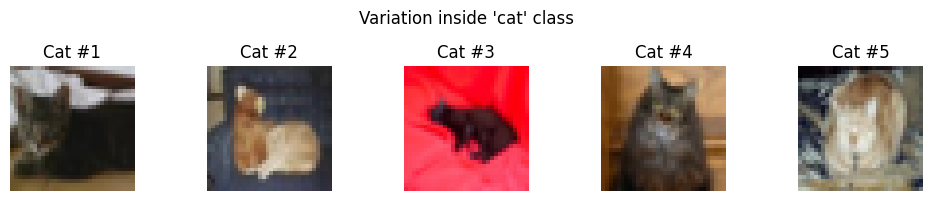

In [ ]:
cat_indices = np.where(y_train == class_names.index("cat"))[0][:5]

plt.figure(figsize=(10,2))
for i, idx in enumerate(cat_indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[idx])
    plt.title(f"Cat #{i+1}")
    plt.axis('off')
plt.suptitle("Variation inside 'cat' class")
plt.tight_layout()
plt.show()


# Result:

We need to make sure that the data contains variations. This proves that there is diversity within the same class, which is important for the model so that it does not save the images!

ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

# Check for duplicate images

In [ ]:
x_train_reshaped = x_train.reshape((x_train.shape[0], -1))
unique_images = np.unique(x_train_reshaped, axis=0)
print("Unique images in training set:", unique_images.shape[0])
print("Total images in training set:", x_train.shape[0])

Unique images in training set: 50000
Total images in training set: 50000


# Result:

I must make sure that the images do not contain duplication. This is very important to avoid adding bias.

ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

# Calculate the percentage for each category

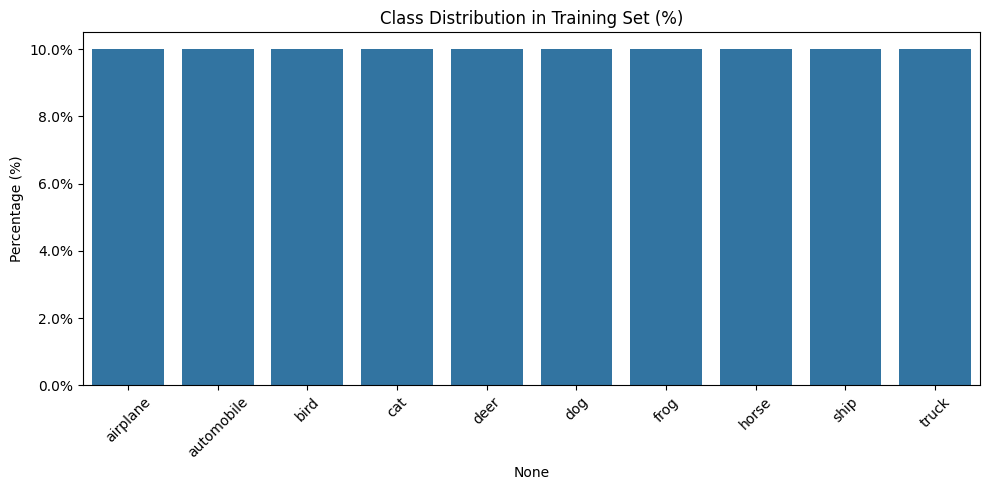

In [ ]:
class_distribution = pd.Series(y_train).value_counts(normalize=True).sort_index()
class_distribution.index = class_names
class_distribution *= 100

plt.figure(figsize=(10,5))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("Percentage (%)")
plt.title("Class Distribution in Training Set (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

# The second stage

Phase 2: Train a custom CNN from scratch on CIFAR-10
 - Build a deep CNN with Conv, BatchNorm, Pooling, Dropout
 - Apply data augmentation to improve generalization
 - Use EarlyStopping and ReduceLROnPlateau for optimization
 - Plot accuracy and loss curves for evaluation


ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

# Define improved CNN model

Normalize images and one-hot encode labels

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


x_train_resized = tf.image.resize(x_train, [128, 128]).numpy()
x_test_resized = tf.image.resize(x_test, [128, 128]).numpy()

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
# datagen.fit(x_train_norm)

# CNN model

In [ ]:
def build_advanced_cnn_functional(input_shape=(128, 128, 3), num_classes=10):
    inputs = Input(shape=input_shape)


    x = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', name="conv1_1")(inputs)
    x = BatchNormalization(name="bn1_1")(x)
    x = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', name="conv1_2")(x)
    x = BatchNormalization(name="bn1_2")(x)
    x = MaxPooling2D(pool_size=(2,2), name="pool1")(x)
    x = Dropout(0.3, name="drop1")(x)


    x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', name="conv2_1")(x)
    x = BatchNormalization(name="bn2_1")(x)
    x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', name="conv2_2")(x)
    x = BatchNormalization(name="bn2_2")(x)
    x = MaxPooling2D(pool_size=(2,2), name="pool2")(x)
    x = Dropout(0.4, name="drop2")(x)


    x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', name="conv3_1")(x)
    x = BatchNormalization(name="bn3_1")(x)
    x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', name="conv3_2")(x)
    x = BatchNormalization(name="bn3_2")(x)
    x = MaxPooling2D(pool_size=(2,2), name="pool3")(x)
    x = Dropout(0.5, name="drop3")(x)


    x = Flatten(name="flatten")(x)
    x = Dense(256, activation='relu', kernel_initializer='he_normal', name="fc1")(x)
    x = Dropout(0.5, name="drop_fc")(x)
    outputs = Dense(num_classes, activation='softmax', name="output")(x)

    model = Model(inputs=inputs, outputs=outputs, name="advanced_cnn_functional")
    return model


# Compile model

In [ ]:
model = model = build_advanced_cnn_functional()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



#  Callbacks


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


# Train the model

In [ ]:
history = model.fit(
    datagen.flow(x_train_norm, y_train_cat, batch_size=64),
    validation_data=(x_test_norm, y_test_cat),
    epochs=80,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Professional models reach 85–87%, very close to peak performance.

# Plot training curves

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on test set

In [ ]:
test_loss, test_acc = model.evaluate(x_test_norm, y_test_cat, verbose=0)
print(f"\n Final Test Accuracy: {test_acc:.4f}")
print(f" Final Test Loss: {test_loss:.4f}")

# Predict probabilities and labels

In [ ]:
y_pred_probs = model.predict(x_test_norm, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluation Metrics

In [ ]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [ ]:
print(f"Accuracy: {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall: {rec:.4f}")
print(f" F1 Score: {f1:.4f}")

# Classification Report

In [ ]:
print("\n Full Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize worst mistakes

In [ ]:
def show_top_errors(num_errors=5):
    errors = []
    for i in range(len(y_test)):
        if y_test[i] != y_pred[i]:
            confidence = np.max(y_pred_probs[i])
            errors.append((i, y_test[i], y_pred[i], confidence))

    errors.sort(key=lambda x: x[3], reverse=True)
    top_errors = errors[:num_errors]

    plt.figure(figsize=(15, 3))
    for i, (idx, true, pred, conf) in enumerate(top_errors):
        plt.subplot(1, num_errors, i + 1)
        plt.imshow(x_test[idx])
        plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}\nConf: {conf:.2f}", color='red')
        plt.axis('off')
    plt.suptitle("Top Confident Mistakes", fontsize=14)
    plt.tight_layout()
    plt.show()

show_top_errors()


# Visualize most confident correct predictions

In [ ]:
def show_top_correct(num=5):
    correct = []
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            confidence = np.max(y_pred_probs[i])
            correct.append((i, y_test[i], y_pred[i], confidence))

    correct.sort(key=lambda x: x[3], reverse=True)
    top_correct = correct[:num]

    plt.figure(figsize=(15, 3))
    for i, (idx, true, pred, conf) in enumerate(top_correct):
        plt.subplot(1, num, i + 1)
        plt.imshow(x_test[idx])
        plt.title(f"{class_names[pred]}\nConf: {conf:.2f}", color='green')
        plt.axis('off')
    plt.suptitle("Most Confident Correct Predictions", fontsize=14)
    plt.tight_layout()
    plt.show()

show_top_correct()

# Export predictions to CSV

In [ ]:
results_df = pd.DataFrame({
    'True_Label': [class_names[i] for i in y_test],
    'Predicted_Label': [class_names[i] for i in y_pred],
    'Confidence': [np.max(p) for p in y_pred_probs]
})
results_df.to_csv("cnn_predictions.csv", index=False)


# Save model

In [ ]:
model.save("cnn_model_scratch_DL2.h5")

 Phase 6: Grad-CAM (Visual Explanation)
 - Apply Grad-CAM to trained CNN model
 - Show where the model focuses in the image
 - Helps interpret model decisions
 - Acts as weak object detection
 - Will be repeated for VGG16 later


# Load model

In [ ]:
model = tf.keras.models.load_model("cnn_model_scratch_DL2.h5")
_ = model.predict(np.expand_dims(x_test_norm[0], axis=0))


In [ ]:
idx = 12
img = x_test_norm[idx]
img_input = np.expand_dims(img, axis=0)
img_tensor = tf.convert_to_tensor(img_input, dtype=tf.float32)

preds = model.predict(img_input, verbose=0)
predicted_class = np.argmax(preds[0])
true_class = y_test[idx]
print(f"Predicted: {class_names[predicted_class]} | True: {class_names[true_class]}")


last_conv_layer_name = "conv3_2"


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)


def display_gradcam(img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = heatmap_colored * alpha + (img * 255).astype(np.uint8)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img[..., ::-1])
    plt.title("Superimposed")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


display_gradcam(img, heatmap)


In [ ]:
num_images = x_test_norm.shape[0]
selected_indices = range(num_images - 5, num_images)


fig, axes = plt.subplots(5, 3, figsize=(12, 10))
fig.suptitle(" Grad-CAM Analysis for Last 5 Test Images", fontsize=16)

for row_idx, idx in enumerate(selected_indices):
    img = x_test_norm[idx]
    img_input = np.expand_dims(img, axis=0)
    img_tensor = tf.convert_to_tensor(img_input, dtype=tf.float32)


    preds = model.predict(img_input, verbose=0)
    predicted_class = np.argmax(preds[0])
    true_class = y_test[idx]

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = heatmap_colored * 0.4 + (img * 255).astype(np.uint8)


    axes[row_idx, 0].imshow(img)
    axes[row_idx, 0].set_title("Original")
    axes[row_idx, 0].axis('off')


    axes[row_idx, 1].imshow(heatmap_resized, cmap='jet')
    axes[row_idx, 1].set_title("Grad-CAM")
    axes[row_idx, 1].axis('off')


    axes[row_idx, 2].imshow(superimposed_img[..., ::-1])
    axes[row_idx, 2].set_title(f"Pred: {class_names[predicted_class]}\nTrue: {class_names[true_class]}")
    axes[row_idx, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
os.makedirs("gradcam_outputs", exist_ok=True)


num_images = x_test_norm.shape[0]
selected_indices = range(num_images - 5, num_images)

for i, idx in enumerate(selected_indices, start=1):
    img = x_test_norm[idx]
    img_input = np.expand_dims(img, axis=0)
    img_tensor = tf.convert_to_tensor(img_input, dtype=tf.float32)


    preds = model.predict(img_input, verbose=0)
    predicted_class = np.argmax(preds[0])
    true_class = y_test[idx]


    heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = heatmap_colored * 0.4 + (img * 255).astype(np.uint8)


    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f"Image #{idx} | Predicted: {class_names[predicted_class]} | True: {class_names[true_class]}", fontsize=13)


    axes[0].imshow(img)
    axes[0].set_title("Original")
    axes[0].axis('off')


    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis('off')


    axes[2].imshow(superimposed_img[..., ::-1])
    axes[2].set_title("Superimposed")
    axes[2].axis('off')

    plt.tight_layout()


    save_path = f"gradcam_outputs/gradcam_img_{i}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Saved: {save_path}")


In [ ]:
shutil.make_archive("GradCAM_Images", 'zip', "gradcam_outputs")
files.download("GradCAM_Images.zip")

# build_cnn_with_separable_conv

In [ ]:
def build_cnn_with_separable_conv(input_shape=(128, 128, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', name="conv1_1")(inputs)
    x = BatchNormalization(name="bn1_1")(x)
    x = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', name="conv1_2")(x)
    x = BatchNormalization(name="bn1_2")(x)
    x = MaxPooling2D(pool_size=(2,2), name="pool1")(x)
    x = Dropout(0.3, name="drop1")(x)


    x = SeparableConv2D(64, (3,3), padding='same', activation='relu', depthwise_initializer='he_normal', pointwise_initializer='he_normal', name="sepconv2_1")(x)
    x = BatchNormalization(name="bn2_1")(x)
    x = SeparableConv2D(64, (3,3), padding='same', activation='relu', depthwise_initializer='he_normal', pointwise_initializer='he_normal', name="sepconv2_2")(x)
    x = BatchNormalization(name="bn2_2")(x)
    x = MaxPooling2D(pool_size=(2,2), name="pool2")(x)
    x = Dropout(0.4, name="drop2")(x)


    x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', name="conv3_1")(x)
    x = BatchNormalization(name="bn3_1")(x)
    x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', name="conv3_2")(x)
    x = BatchNormalization(name="bn3_2")(x)
    x = MaxPooling2D(pool_size=(2,2), name="pool3")(x)
    x = Dropout(0.5, name="drop3")(x)


    x = Flatten(name="flatten")(x)
    x = Dense(256, activation='relu', kernel_initializer='he_normal', name="fc1")(x)
    x = Dropout(0.5, name="drop_fc")(x)
    outputs = Dense(num_classes, activation='softmax', name="output")(x)


    model = Model(inputs=inputs, outputs=outputs, name="cnn_with_separable")
    return model

In [ ]:
model_separable = build_cnn_with_separable_conv()

Compile

In [ ]:
model_separable.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_model_separable.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

callbacks = [early_stop, reduce_lr, checkpoint]

history_separable = model_separable.fit(
    datagen.flow(x_train_norm, y_train_cat, batch_size=64),
    validation_data=(x_test_norm, y_test_cat),
    epochs=80,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
test_loss, test_acc = model_separable.evaluate(x_test_norm, y_test_cat, verbose=0)
print(f" Test Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")

In [ ]:
y_pred_probs = model_separable.predict(x_test_norm, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion Matrix + Heatmap

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Classification Report

In [ ]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(" Classification Report model 2:\n")
print(report)

# Worst case predictions

In [ ]:
confidences = np.max(y_pred_probs, axis=1)
errors = np.where(y_pred != y_true)[0]
sorted_errors = errors[np.argsort(-confidences[errors])]

print(f" Worst confident wrong predictions Top 5:")
for i in sorted_errors[:5]:
    print(f"Image {i} | Predicted: {class_names[y_pred[i]]} | True: {class_names[y_true[i]]} | Confidence: {confidences[i]:.4f}")


# Strongest correct predictions

In [ ]:
correct = np.where(y_pred == y_true)[0]
sorted_correct = correct[np.argsort(-confidences[correct])]

print(f"\n Top confident correct predictions Top 5:")
for i in sorted_correct[:5]:
    print(f"Image {i} | Class: {class_names[y_true[i]]} | Confidence: {confidences[i]:.4f}")

# Transfer Learning (VGG16)

In [ ]:
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [ ]:
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)  # XLA Compilation


x_train_resized = tf.image.resize(x_train, [96, 96])
x_test_resized = tf.image.resize(x_test, [96, 96])
x_train_vgg = preprocess_input(x_train_resized.numpy())
x_test_vgg = preprocess_input(x_test_resized.numpy())


train_ds = tf.data.Dataset.from_tensor_slices((x_train_vgg, y_train_cat)).shuffle(2048).batch(128).cache().prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_test_vgg, y_test_cat)).batch(128).cache().prefetch(tf.data.AUTOTUNE)


base_model = VGG16(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(10, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


model.fit(train_ds, validation_data=val_ds, epochs=30,
          callbacks=[early_stop, reduce_lr], verbose=1)


for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_ds, validation_data=val_ds, epochs=10,
          callbacks=[early_stop, reduce_lr], verbose=1)


test_loss, test_acc = model.evaluate(val_ds, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

In [ ]:
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)


mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)


x_train_resized = tf.image.resize(x_train, [96, 96])
x_test_resized = tf.image.resize(x_test, [96, 96])
x_train_vgg = preprocess_input(x_train_resized.numpy())
x_test_vgg = preprocess_input(x_test_resized.numpy())


train_ds = tf.data.Dataset.from_tensor_slices((x_train_vgg, y_train_cat)).shuffle(2048).batch(128).cache().prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_test_vgg, y_test_cat)).batch(128).cache().prefetch(tf.data.AUTOTUNE)


base_model = VGG16(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(10, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


history1 = model.fit(train_ds, validation_data=val_ds, epochs=80,
                     callbacks=[early_stop, reduce_lr], verbose=1)

for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model.fit(train_ds, validation_data=val_ds, epochs=10,
                     callbacks=[early_stop, reduce_lr], verbose=1)



In [ ]:
for layer in model.layers:
    print(layer.name)

In [ ]:
model.save("vgg_light_finetuned22.h5")

# model summary


In [ ]:
model.summary()

# Evaluate the model on test set

In [ ]:
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)


print("Classification Report:\n", classification_report(y_true, y_pred))

#Confusion Matrix


In [ ]:
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# High Confidence Errors

In [ ]:
wrong_indices = np.where(y_pred != y_true)[0]
wrong_confidences = np.max(y_pred_probs[wrong_indices], axis=1)
top_wrong = wrong_indices[np.argsort(wrong_confidences)[-10:]]


plt.figure(figsize=(15, 5))
for i, idx in enumerate(top_wrong):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_resized[idx].numpy().astype("uint8"))
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred[idx]}\nConf: {wrong_confidences[np.argsort(wrong_confidences)[-10:]][i]:.2f}")
    plt.axis("off")
plt.suptitle("Most Confident Wrong Predictions")
plt.show()


# Top Confident Correct Predictions

In [ ]:
correct_indices = np.where(y_pred == y_true)[0]
correct_confidences = np.max(y_pred_probs[correct_indices], axis=1)
top_correct = correct_indices[np.argsort(correct_confidences)[-10:]]

plt.figure(figsize=(15, 5))
for i, idx in enumerate(top_correct):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_resized[idx].numpy().astype("uint8"))
    plt.title(f"Label: {y_true[idx]}\nConf: {correct_confidences[np.argsort(correct_confidences)[-10:]][i]:.2f}")
    plt.axis("off")
plt.suptitle("Most Confident Correct Predictions")
plt.show()


# Accuracy & Loss Curves

In [ ]:
test_loss, test_acc = model.evaluate(val_ds, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

def merge_histories(h1, h2):
    merged = {}
    for key in h1.history:
        merged[key] = h1.history[key] + h2.history[key]
    return merged

def plot_training_curves(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


merged_history = merge_histories(history1, history2)
plot_training_curves(merged_history)

# Grad-CAM on VGG model

In [ ]:
index = 7
img_input = x_test_vgg[index]
original_img = x_test_resized[index].numpy()


img_tensor = tf.convert_to_tensor(np.expand_dims(img_input, axis=0))


last_conv_layer_name = "block5_conv3"


grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)


with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_tensor)
    predicted_class = tf.argmax(predictions[0])
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)


heatmap = tf.squeeze(heatmap)


if len(heatmap.shape) != 2 or tf.reduce_max(heatmap).numpy() == 0:
    heatmap = tf.ones((12, 12))


heatmap = np.maximum(heatmap, 0)
heatmap = heatmap / np.max(heatmap)


heatmap = np.uint8(255 * heatmap)
heatmap = cv2.resize(heatmap, (96, 96))
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


original_img_norm = (original_img - original_img.min()) / (original_img.max() - original_img.min())
original_img_uint8 = np.uint8(original_img_norm * 255)


alpha = 0.4
overlay = cv2.addWeighted(original_img_uint8, 1 - alpha, heatmap_color, alpha, 0)


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_img_uint8.astype('uint8'))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Overlayed - Pred: {predicted_class.numpy()}")
plt.imshow(overlay)
plt.axis('off')

plt.tight_layout()
plt.show()


# The Bonus Autoencoder + KMeans + visualization by T-SNE

In [ ]:
!pip install tensorflow --quiet

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_data = np.concatenate((x_train, x_test), axis=0).astype('float32') / 255.0
y_data = np.concatenate((y_train, y_test), axis=0).flatten()


input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, 3, activation='relu', padding='same')(input_img)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
encoded = MaxPooling2D(2, padding='same')(x)  # (8, 8, 64)

x = Conv2D(64, 3, activation='relu', padding='same')(encoded)
x = UpSampling2D(2)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = UpSampling2D(2)(x)
decoded = Conv2D(3, 3, activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(1e-3), loss='mse')


autoencoder.fit(x_data[:40000], x_data[:40000],
                epochs=15, batch_size=256,
                validation_split=0.1, shuffle=True)


encoder = Model(input_img, encoded)
features = encoder.predict(x_data[:10000])
features_flat = features.reshape((features.shape[0], -1))
true_labels = y_data[:10000]


kmeans = KMeans(n_clusters=10, random_state=42)
pred_clusters = kmeans.fit_predict(features_flat)


ari_score = adjusted_rand_score(true_labels, pred_clusters)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")


tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features_flat)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=pred_clusters, palette='tab10', legend='full', s=20)
plt.title("t-SNE of Encoded Features + KMeans Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.show()


def show_cluster_examples(images, labels, cluster_ids, samples_per_cluster=5):
    plt.figure(figsize=(samples_per_cluster*2, 20))
    for cluster in range(10):
        idxs = np.where(cluster_ids == cluster)[0][:samples_per_cluster]
        for i, idx in enumerate(idxs):
            plt.subplot(10, samples_per_cluster, cluster*samples_per_cluster + i + 1)
            plt.imshow(images[idx])
            plt.axis('off')
            if i == 0:
                plt.ylabel(f"Cluster {cluster}", fontsize=12)
    plt.suptitle("Example Images from Each Cluster", fontsize=16)
    plt.tight_layout()
    plt.show()

show_cluster_examples(x_data[:10000], true_labels, pred_clusters)


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test]).flatten()

x_subset = x_data[:10000]
y_subset = y_data[:10000]

x_resized = tf.image.resize(x_subset, [224, 224]).numpy()
x_preprocessed = preprocess_input(x_resized)

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = vgg.output
x = GlobalAveragePooling2D()(x)
feature_model = Model(inputs=vgg.input, outputs=x)


features = feature_model.predict(x_preprocessed, batch_size=64, verbose=1)


kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(features)


ari = adjusted_rand_score(y_subset, clusters)
print(f"\n Adjusted Rand Index (ARI): {ari:.4f}")

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
tsne_result = tsne.fit_transform(features)


df = pd.DataFrame({
    'x': tsne_result[:, 0],
    'y': tsne_result[:, 1],
    'cluster': clusters
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='tab10', s=20)
plt.title(f"t-SNE of VGG16 Features + KMeans (ARI: {ari:.4f})")
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test]).flatten()

x_subset = x_data[:10000]
y_subset = y_data[:10000]

x_resized = tf.image.resize(x_subset, [224, 224]).numpy()
x_preprocessed = preprocess_input(x_resized)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
feature_output = Dropout(0.4)(x)

feature_model = Model(inputs=base_model.input, outputs=feature_output)


features = feature_model.predict(x_preprocessed, batch_size=64, verbose=1)


kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(features)


ari = adjusted_rand_score(y_subset, clusters)
print(f"\n Adjusted Rand Index (ARI): {ari:.4f}")


df_results = pd.DataFrame({
    'Image_Index': np.arange(len(y_subset)),
    'True_Label': y_subset,
    'Cluster': clusters
})
df_results.to_csv("vgg_clusters.csv", index=False)


tsne_result = TSNE(n_components=2, perplexity=50, random_state=42).fit_transform(features)
df_tsne = pd.DataFrame({
    'x': tsne_result[:, 0],
    'y': tsne_result[:, 1],
    'cluster': clusters
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster', palette='tab10', s=20)
plt.title(f"t-SNE of VGG16 Features + KMeans Clustering\nARI: {ari:.4f}")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Cluster")
plt.show()


def show_cluster_examples(images, cluster_ids, samples_per_cluster=5):
    plt.figure(figsize=(samples_per_cluster * 2, 20))
    for cluster in range(10):
        idxs = np.where(cluster_ids == cluster)[0][:samples_per_cluster]
        for i, idx in enumerate(idxs):
            plt.subplot(10, samples_per_cluster, cluster * samples_per_cluster + i + 1)
            plt.imshow(images[idx])
            plt.axis('off')
            if i == 0:
                plt.ylabel(f"Cluster {cluster}", fontsize=12)
    plt.suptitle("Example Images from Each Cluster", fontsize=16)
    plt.tight_layout()
    plt.show()

show_cluster_examples(x_subset, clusters)
